# Instalação

In [ ]:
!pip install pgmpy

In [ ]:
!pip install networkx

# Inferência Exata

### Construção da Rede Bayesiana
Construindo uma Rede Bayesiana com as variáveis fornecidas no enunciado, com os nós definidos em ordem topológica:




In [ ]:
from pgmpy.models import BayesianModel

symptom_model = BayesianModel([('G', 'A'), 
                               ('A', 'S'),
                               ('B', 'S')])

## Grafo Acíclico Direcionado
Agora criando um Grafo Acíclico Direcionado para visualização da rede bayesiana:

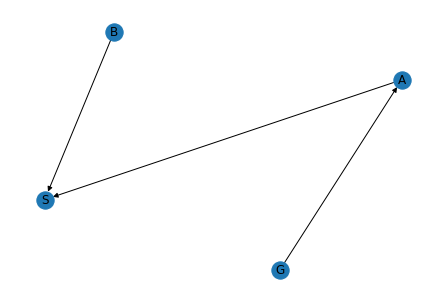

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(symptom_model, with_labels = True); 
plt.show()

## Distribuições de Probabilidade Condicional

Agora, vamos especificar as Distribuições de Probabilidade Condicional para as variáveis da rede, de acordo com os valores fornecidos no enunciado:

In [ ]:
from pgmpy.factors.discrete import TabularCPD

cpd_G = TabularCPD( variable='G', 
                    variable_card=2,
                    values=[[0.1], [0.9]],
                    state_names={'G': ['+g', '-g']}
                  )

cpd_A = TabularCPD( variable='A', 
                    variable_card=2,
                    values=[[1.0, 0.1],
                            [0.0, 0.9]
                           ],
                    state_names={ 'A': ['+a', '-a'],
                                  'G': ['+g', '-g']                                          
                                },
                    evidence=['G'], 
                    evidence_card=[2]
                  )

cpd_B = TabularCPD( variable='B', 
                    variable_card=2,
                    values=[[0.4], [0.6]],
                    state_names={'B': ['+b', '-b']}
                  )

cpd_S = TabularCPD( variable='S', 
                    variable_card=2,
                    values=[[1.0, 0.9, 0.8, 0.1],
                            [0.0, 0.1, 0.2, 0.9]
                           ],
                    state_names={ 'S': ['+s', '-s'],
                                  'A': ['+a', '-a'],
                                  'B': ['+b', '-b'],
                                },
                    evidence=['A', 'B'], 
                    evidence_card=[2,2]
                   )

Adicionando cada CPD a sua variável correspondente no grafo da Rede Bayesiana:

In [ ]:
symptom_model.add_cpds(cpd_G, cpd_A, cpd_B, cpd_S)

Verificando sintáticamente a rede bayesiana:

In [ ]:
symptom_model.check_model()

True

## Realizando Inferências

Agora podemos realizar inferências sobre o modelo construído.

In [ ]:
from pgmpy.inference import VariableElimination

In [ ]:
symptom_infer = VariableElimination(symptom_model)

$\ i. Pr(+g, +a, +b, +s) = 0.04$





In [ ]:
joint = symptom_infer.query(variables=['G', 'A', 'B', 'S'])
print(joint)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+-------+-------+-------+-------+----------------+
| S     | A     | B     | G     |   phi(S,A,B,G) |
+=======+=======+=======+=======+================+
| S(+s) | A(+a) | B(+b) | G(+g) |         0.0400 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(+a) | B(+b) | G(-g) |         0.0360 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(+a) | B(-b) | G(+g) |         0.0540 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(+a) | B(-b) | G(-g) |         0.0486 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(-a) | B(+b) | G(+g) |         0.0000 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(-a) | B(+b) | G(-g) |         0.2592 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(-a) | B(-b) | G(+g) |         0.0000 |
+-------+-------+-------+-------+----------------+
| S(+s) | A(-a) | B(-b) | G(-g) |         0.0486 |
+-------+-------+-------+-------+----------------+
| S(-s) | A(+a) | B(+b) | G(+g)

 $\ ii. Pr(+a) = 0.19$

In [ ]:
prob = symptom_infer.query(variables=['A'])
print(prob)

Eliminating: G: 100%|██████████| 3/3 [00:00<00:00, 412.47it/s]

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(+a) |   0.1900 |
+-------+----------+
| A(-a) |   0.8100 |
+-------+----------+


$\ iii. Pr(+a \mid +b) = 0.19 $


As variáveis A e B são independentes, logo o valor da probabilidade é $P(A=+a)$

In [ ]:
prob = symptom_infer.query(variables=['A'], evidence = {'B' : '+b'})
print(prob)

Eliminating: G: 100%|██████████| 2/2 [00:00<00:00, 424.40it/s]

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(+a) |   0.1900 |
+-------+----------+
| A(-a) |   0.8100 |
+-------+----------+


$\ iv. Pr(+a \mid +s, +b) = 0.2267$


In [ ]:
prob = symptom_infer.query(variables=['A'], evidence = {'S': '+s','B' : '+b'})
print(prob)

Eliminating: G: 100%|██████████| 1/1 [00:00<00:00, 226.24it/s]

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(+a) |   0.2267 |
+-------+----------+
| A(-a) |   0.7733 |
+-------+----------+


$\ v. Pr(+g \mid +a) = 0.5263$


In [ ]:
prob = symptom_infer.query(variables=['G'], evidence = {'A': '+a'})
print(prob)

Eliminating: S: 100%|██████████| 2/2 [00:00<00:00, 491.86it/s]

+-------+----------+
| G     |   phi(G) |
+=======+==========+
| G(+g) |   0.5263 |
+-------+----------+
| G(-g) |   0.4737 |
+-------+----------+


$\ vi.Pr(+g \mid +b) = 0.1 $


In [ ]:
prob = symptom_infer.query(variables=['G'], evidence = {'B': '+b'})
print(prob)

Eliminating: A: 100%|██████████| 2/2 [00:00<00:00, 429.41it/s]

+-------+----------+
| G     |   phi(G) |
+=======+==========+
| G(+g) |   0.1000 |
+-------+----------+
| G(-g) |   0.9000 |
+-------+----------+


# Inferência Aproximada

## Construção da Rede Bayesiana
Construindo a rede bayesiana pedida no enunciado, com os nós definidos em ordem topológica:

In [ ]:
grass_model = BayesianModel([ ('R', 'S'), 
                              ('R', 'G'),
                              ('S', 'G')])

## Grafo Acíclico Direcionado
Criando um Grafo Acíclico Direcionado para visualização:

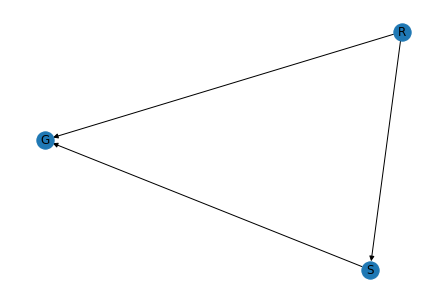

In [ ]:
nx.draw(grass_model, with_labels = True); 
plt.show()

## Distribuições de Probabilidade Condicional
Especificando as Distribuições de Probabilidade Condicional para as variáveis da rede, de acordo com os valores fornecidos no enunciado:

In [ ]:
cpd_R = TabularCPD( variable='R', 
                    variable_card=2,
                    values=[[0.2], [0.8]],
                    state_names={'R': ['T', 'F']}
                  )

cpd_S = TabularCPD( variable='S', 
                    variable_card=2,
                    values=[[0.01, 0.4],
                            [0.99, 0.6]
                           ],
                    state_names={'S': ['T', 'F'],
                                 'R': ['T', 'F']
                                },
                    evidence=['R'],
                    evidence_card=[2]
                  )

cpd_G = TabularCPD( variable='G', 
                    variable_card=2,
                    values=[[0.01, 0.01, 0.01, 0.4],
                            [0.99, 0.99, 0.99, 0.6]
                           ],
                    state_names={ 'G': ['T', 'F'],
                                  'S': ['T', 'F'],
                                  'R': ['T', 'F'],
                                },
                    evidence=['S', 'R'], 
                    evidence_card=[2,2]
                   )

Adicionando cada CPD a sua variável correspondente no grafo da Rede Bayesiana:

In [ ]:
grass_model.add_cpds(cpd_R, cpd_S, cpd_G)

Verificando sintáticamente a rede bayesiana:

In [ ]:
grass_model.check_model()

True

## Implementação de Algoritmos

Para a implementação dos métodos de amostragem na rede bayesiana, usaremos a função auxiliar abaixo, que tem como objetivo realizar uma dada variável da rede bayesiana considerando sua cpd e os valores dos nós pais para a variável, caso existam:

In [ ]:
import numpy as np

def realize_variable(bayesian_model, variable_name, parents):
  """
    Gera um valor para uma variável da rede bayesiana, de acordo com sua cpd 
    e os valores dos nós pais para essa variável, caso existam.
  """
  cpd_table = bayesian_model.get_cpds(variable_name)
  variables_in_cpd = cpd_table.variables
  cpd = cpd_table

  if parents:
    # Verifica se existem nós pais para a variável.
    conditioners = []
    for key, value in parents.items():
      if key == variable_name:
        continue
      if key not in variables_in_cpd:
        continue
      conditioners.append((key, value))
    cpd = cpd_table.reduce(conditioners, inplace  = False)
  
  state_names_dict = bayesian_model.get_cpds(variable_name).state_names

  values = state_names_dict[variable_name]
  probs = cpd.get_values()

  # Gera um valor para a variável.
  cum_sum = np.cumsum(probs)
  s = np.random.uniform(0,1)
  for j in range(cum_sum.shape[0]):
    if s < cum_sum[j]:
      return values[j]

### Amostragem a Priori

Agora implementando o algoritmo do método de Amostragem a Priori, utilizando a assinatura fornecida no enuncaido do trabalho:

In [ ]:
def amostragem_a_priori(rede_bayesiana, q, obs, num_amostras):
  """
    Faz a coleta de amostras utilizando o método de Amostragem a Priori e
    retorna uma aproximação para os valores possíveis da variável q na consulta
    P(q | obs)
  """

  q_probs = dict() # Retorno da função, um dicionario com elementos (k,v) 
                   # onde k é um valor possível da variável q,
                   # e v é a probabilidade aproximada desse valor ocorrer 
                   # computada pela função.

  samples = dict() # Dicionário para armazenar as amostras colhidas.
                   # Seus elementos são da forma (k,v), em que k é o indíce
                   # da amostra colhida, e v é a própria amostra.
                   # Ex: {1: {Rain: 'T', Sprinkler: 'F, Wet: 'T' }}

  n_samples_evidence_true = 0 # Variável auxiliar para armazenar o número
                              # de amostras em que a evidência obs acontece.

  q_values = [] # Lista auxiliar para armazenar todos os valores de q nas 
                # amostras em que obs acontece.
  
  variables = grass_model.nodes()

  for i in range(1, num_amostras+1):
    # Coleta de amostras seguindo a ordem topológica da rede bayesiana.

    parents = dict() # Armazena o valor dos nós pais da variável atual sendo 
                     # amostrada e é incrementado de forma que ao final do loop
                     # equivalha à própria amostra.
    sample = dict()

    for v in variables:
      parents[v] = realize_variable(rede_bayesiana, v, parents) 
      sample = parents
    samples[i] = sample
  
  print("Amostras:\n", samples)

  for sample in samples.values():
    # Consulta com base nas amostras colhidas.
    
    if obs:
      # Caso obs exista, verifica se obs está contido em cada amostra.
      # obs_is_subset_of_sample retorna True se obs está contido em sample.
      obs_is_subset_of_sample = all(sample.get(key, None) == value for key, value in obs.items())
      if obs_is_subset_of_sample:
        # Se a amostra contém a evidência, adiciona o valor da chave q na lista 
        # q_values.
        n_samples_evidence_true += 1
        q_values.append(sample[q])
    else:
      # Caso obs não exista, adiciona todos os valores das chaves q na lista 
      # q_values.
      n_samples_evidence_true = num_amostras
      q_values.append(sample[q])
    
  # Armazena a quantidade de ocorrências para cada possível valor de q e
  # obtém a probabilidade fazendo a divisão por n_sample_evidence_true.
  q_probs = {i: (q_values.count(i)/n_samples_evidence_true) for i in q_values}

  print('Valor aproximado para a consulta: ')
  return q_probs




#### Realizando Inferências

Agora realizando as consultas pedidas pelo enunciado usando Amostragem a Priori:


$\ i. Pr(R) $

Como não existe evidência, passamos o parâmetro obs como None para a função.




*   **Para 5 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'R', None, 5)

Amostras:
 {1: {'R': 'F', 'S': 'T', 'G': 'F'}, 2: {'R': 'F', 'S': 'T', 'G': 'F'}, 3: {'R': 'F', 'S': 'F', 'G': 'F'}, 4: {'R': 'F', 'S': 'F', 'G': 'T'}, 5: {'R': 'T', 'S': 'F', 'G': 'F'}}
Valor aproximado para a consulta: 


{'F': 0.8, 'T': 0.2}

*   **Para 50 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'R', None, 50)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'T'}, 2: {'R': 'F', 'S': 'F', 'G': 'F'}, 3: {'R': 'T', 'S': 'F', 'G': 'F'}, 4: {'R': 'F', 'S': 'T', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}, 6: {'R': 'T', 'S': 'F', 'G': 'F'}, 7: {'R': 'T', 'S': 'F', 'G': 'F'}, 8: {'R': 'F', 'S': 'T', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'T'}, 11: {'R': 'F', 'S': 'F', 'G': 'T'}, 12: {'R': 'T', 'S': 'F', 'G': 'F'}, 13: {'R': 'F', 'S': 'F', 'G': 'T'}, 14: {'R': 'T', 'S': 'F', 'G': 'F'}, 15: {'R': 'F', 'S': 'T', 'G': 'F'}, 16: {'R': 'F', 'S': 'T', 'G': 'F'}, 17: {'R': 'F', 'S': 'T', 'G': 'F'}, 18: {'R': 'F', 'S': 'T', 'G': 'F'}, 19: {'R': 'F', 'S': 'F', 'G': 'T'}, 20: {'R': 'F', 'S': 'F', 'G': 'F'}, 21: {'R': 'F', 'S': 'T', 'G': 'F'}, 22: {'R': 'F', 'S': 'T', 'G': 'F'}, 23: {'R': 'F', 'S': 'F', 'G': 'F'}, 24: {'R': 'F', 'S': 'T', 'G': 'F'}, 25: {'R': 'T', 'S': 'F', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'F'}, 27: {'R': 'F', 'S': 'F', 'G': 'T'}, 28: {'R': 'F', 'S': 'T', 

{'F': 0.74, 'T': 0.26}

*   **Para 500 amostras**:







In [ ]:
amostragem_a_priori(grass_model, 'R', None, 500)

Amostras:
 {1: {'R': 'F', 'S': 'T', 'G': 'F'}, 2: {'R': 'F', 'S': 'F', 'G': 'T'}, 3: {'R': 'T', 'S': 'F', 'G': 'F'}, 4: {'R': 'T', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}, 6: {'R': 'F', 'S': 'T', 'G': 'F'}, 7: {'R': 'F', 'S': 'F', 'G': 'T'}, 8: {'R': 'T', 'S': 'F', 'G': 'F'}, 9: {'R': 'T', 'S': 'F', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'F'}, 11: {'R': 'F', 'S': 'T', 'G': 'F'}, 12: {'R': 'F', 'S': 'F', 'G': 'F'}, 13: {'R': 'T', 'S': 'F', 'G': 'F'}, 14: {'R': 'F', 'S': 'F', 'G': 'T'}, 15: {'R': 'F', 'S': 'F', 'G': 'F'}, 16: {'R': 'F', 'S': 'T', 'G': 'F'}, 17: {'R': 'T', 'S': 'F', 'G': 'F'}, 18: {'R': 'F', 'S': 'F', 'G': 'T'}, 19: {'R': 'T', 'S': 'F', 'G': 'F'}, 20: {'R': 'T', 'S': 'F', 'G': 'F'}, 21: {'R': 'F', 'S': 'F', 'G': 'F'}, 22: {'R': 'T', 'S': 'F', 'G': 'F'}, 23: {'R': 'F', 'S': 'T', 'G': 'F'}, 24: {'R': 'T', 'S': 'F', 'G': 'F'}, 25: {'R': 'F', 'S': 'F', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'T'}, 27: {'R': 'F', 'S': 'F', 'G': 'F'}, 28: {'R': 'F', 'S': 'F', 

{'F': 0.826, 'T': 0.174}

$\ ii. Pr(S) $




*   **Para 5 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'S', None, 5)

Amostras:
 {1: {'R': 'F', 'S': 'T', 'G': 'F'}, 2: {'R': 'F', 'S': 'F', 'G': 'T'}, 3: {'R': 'F', 'S': 'F', 'G': 'T'}, 4: {'R': 'F', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}}
Valor aproximado para a consulta: 


{'F': 0.8, 'T': 0.2}

*   **Para 50 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'S', None, 50)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'F'}, 2: {'R': 'F', 'S': 'F', 'G': 'F'}, 3: {'R': 'F', 'S': 'F', 'G': 'F'}, 4: {'R': 'F', 'S': 'F', 'G': 'T'}, 5: {'R': 'T', 'S': 'F', 'G': 'F'}, 6: {'R': 'T', 'S': 'F', 'G': 'F'}, 7: {'R': 'F', 'S': 'F', 'G': 'F'}, 8: {'R': 'T', 'S': 'F', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'F'}, 11: {'R': 'T', 'S': 'F', 'G': 'F'}, 12: {'R': 'F', 'S': 'T', 'G': 'F'}, 13: {'R': 'F', 'S': 'F', 'G': 'F'}, 14: {'R': 'F', 'S': 'F', 'G': 'F'}, 15: {'R': 'T', 'S': 'F', 'G': 'F'}, 16: {'R': 'F', 'S': 'T', 'G': 'F'}, 17: {'R': 'T', 'S': 'F', 'G': 'F'}, 18: {'R': 'F', 'S': 'F', 'G': 'F'}, 19: {'R': 'T', 'S': 'F', 'G': 'F'}, 20: {'R': 'T', 'S': 'F', 'G': 'F'}, 21: {'R': 'F', 'S': 'F', 'G': 'T'}, 22: {'R': 'F', 'S': 'F', 'G': 'F'}, 23: {'R': 'F', 'S': 'F', 'G': 'F'}, 24: {'R': 'F', 'S': 'T', 'G': 'F'}, 25: {'R': 'T', 'S': 'F', 'G': 'F'}, 26: {'R': 'F', 'S': 'T', 'G': 'F'}, 27: {'R': 'F', 'S': 'F', 'G': 'F'}, 28: {'R': 'T', 'S': 'F', 

{'F': 0.7, 'T': 0.3}

*   **Para 500 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'S', None, 500)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'T'}, 2: {'R': 'F', 'S': 'F', 'G': 'T'}, 3: {'R': 'T', 'S': 'F', 'G': 'F'}, 4: {'R': 'T', 'S': 'F', 'G': 'F'}, 5: {'R': 'T', 'S': 'F', 'G': 'F'}, 6: {'R': 'T', 'S': 'F', 'G': 'F'}, 7: {'R': 'F', 'S': 'F', 'G': 'T'}, 8: {'R': 'F', 'S': 'T', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'T'}, 11: {'R': 'F', 'S': 'T', 'G': 'F'}, 12: {'R': 'F', 'S': 'T', 'G': 'F'}, 13: {'R': 'T', 'S': 'F', 'G': 'F'}, 14: {'R': 'F', 'S': 'F', 'G': 'F'}, 15: {'R': 'F', 'S': 'T', 'G': 'F'}, 16: {'R': 'F', 'S': 'F', 'G': 'F'}, 17: {'R': 'F', 'S': 'T', 'G': 'F'}, 18: {'R': 'F', 'S': 'T', 'G': 'F'}, 19: {'R': 'F', 'S': 'F', 'G': 'F'}, 20: {'R': 'F', 'S': 'T', 'G': 'F'}, 21: {'R': 'F', 'S': 'T', 'G': 'F'}, 22: {'R': 'F', 'S': 'F', 'G': 'T'}, 23: {'R': 'F', 'S': 'T', 'G': 'F'}, 24: {'R': 'F', 'S': 'F', 'G': 'T'}, 25: {'R': 'F', 'S': 'T', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'T'}, 27: {'R': 'T', 'S': 'F', 'G': 'F'}, 28: {'R': 'F', 'S': 'T', 

{'F': 0.718, 'T': 0.282}

$\ iii. Pr(G) $




*   **Para 5 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'G', None, 5)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'T'}, 2: {'R': 'F', 'S': 'F', 'G': 'T'}, 3: {'R': 'T', 'S': 'F', 'G': 'F'}, 4: {'R': 'T', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}}
Valor aproximado para a consulta: 


{'F': 0.6, 'T': 0.4}

*   **Para 50 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'G', None, 50)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'F'}, 2: {'R': 'F', 'S': 'F', 'G': 'F'}, 3: {'R': 'F', 'S': 'T', 'G': 'F'}, 4: {'R': 'F', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'T'}, 6: {'R': 'F', 'S': 'F', 'G': 'F'}, 7: {'R': 'T', 'S': 'F', 'G': 'F'}, 8: {'R': 'F', 'S': 'T', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'T'}, 11: {'R': 'F', 'S': 'F', 'G': 'F'}, 12: {'R': 'T', 'S': 'F', 'G': 'F'}, 13: {'R': 'T', 'S': 'F', 'G': 'F'}, 14: {'R': 'F', 'S': 'T', 'G': 'F'}, 15: {'R': 'F', 'S': 'T', 'G': 'F'}, 16: {'R': 'F', 'S': 'F', 'G': 'T'}, 17: {'R': 'T', 'S': 'F', 'G': 'F'}, 18: {'R': 'F', 'S': 'F', 'G': 'F'}, 19: {'R': 'T', 'S': 'F', 'G': 'F'}, 20: {'R': 'T', 'S': 'F', 'G': 'F'}, 21: {'R': 'F', 'S': 'F', 'G': 'T'}, 22: {'R': 'F', 'S': 'F', 'G': 'F'}, 23: {'R': 'F', 'S': 'T', 'G': 'F'}, 24: {'R': 'F', 'S': 'F', 'G': 'T'}, 25: {'R': 'F', 'S': 'T', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'F'}, 27: {'R': 'F', 'S': 'F', 'G': 'F'}, 28: {'R': 'T', 'S': 'F', 

{'F': 0.84, 'T': 0.16}

*   **Para 500 amostras:**







In [ ]:
amostragem_a_priori(grass_model, 'G', None, 500)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'T'}, 2: {'R': 'F', 'S': 'F', 'G': 'T'}, 3: {'R': 'F', 'S': 'F', 'G': 'F'}, 4: {'R': 'F', 'S': 'F', 'G': 'T'}, 5: {'R': 'F', 'S': 'T', 'G': 'F'}, 6: {'R': 'F', 'S': 'T', 'G': 'F'}, 7: {'R': 'F', 'S': 'F', 'G': 'F'}, 8: {'R': 'F', 'S': 'T', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'T'}, 11: {'R': 'T', 'S': 'F', 'G': 'F'}, 12: {'R': 'F', 'S': 'F', 'G': 'F'}, 13: {'R': 'T', 'S': 'F', 'G': 'F'}, 14: {'R': 'T', 'S': 'F', 'G': 'F'}, 15: {'R': 'F', 'S': 'T', 'G': 'F'}, 16: {'R': 'F', 'S': 'T', 'G': 'F'}, 17: {'R': 'F', 'S': 'F', 'G': 'T'}, 18: {'R': 'F', 'S': 'F', 'G': 'T'}, 19: {'R': 'T', 'S': 'F', 'G': 'F'}, 20: {'R': 'F', 'S': 'F', 'G': 'T'}, 21: {'R': 'F', 'S': 'F', 'G': 'T'}, 22: {'R': 'F', 'S': 'F', 'G': 'F'}, 23: {'R': 'F', 'S': 'F', 'G': 'F'}, 24: {'R': 'T', 'S': 'F', 'G': 'F'}, 25: {'R': 'F', 'S': 'T', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'F'}, 27: {'R': 'T', 'S': 'F', 'G': 'F'}, 28: {'R': 'F', 'S': 'F', 

{'F': 0.786, 'T': 0.214}

$\ iv. Pr(G \mid S = True) $

Agora passamos um parâmetro para obs.




*   **Para 5 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'T'
amostragem_a_priori(grass_model, 'G', obs, 5)

Amostras:
 {1: {'R': 'F', 'S': 'T', 'G': 'F'}, 2: {'R': 'F', 'S': 'T', 'G': 'F'}, 3: {'R': 'F', 'S': 'F', 'G': 'T'}, 4: {'R': 'F', 'S': 'F', 'G': 'T'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}}
Valor aproximado para a consulta: 


{'F': 1.0}

*   **Para 50 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'T'
amostragem_a_priori(grass_model, 'G', obs, 50)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'F'}, 2: {'R': 'T', 'S': 'F', 'G': 'F'}, 3: {'R': 'F', 'S': 'F', 'G': 'T'}, 4: {'R': 'F', 'S': 'T', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}, 6: {'R': 'F', 'S': 'F', 'G': 'T'}, 7: {'R': 'F', 'S': 'T', 'G': 'F'}, 8: {'R': 'F', 'S': 'F', 'G': 'T'}, 9: {'R': 'F', 'S': 'T', 'G': 'F'}, 10: {'R': 'F', 'S': 'F', 'G': 'T'}, 11: {'R': 'F', 'S': 'T', 'G': 'F'}, 12: {'R': 'F', 'S': 'F', 'G': 'T'}, 13: {'R': 'F', 'S': 'F', 'G': 'T'}, 14: {'R': 'F', 'S': 'T', 'G': 'F'}, 15: {'R': 'F', 'S': 'F', 'G': 'F'}, 16: {'R': 'F', 'S': 'F', 'G': 'F'}, 17: {'R': 'T', 'S': 'F', 'G': 'F'}, 18: {'R': 'F', 'S': 'T', 'G': 'F'}, 19: {'R': 'F', 'S': 'F', 'G': 'T'}, 20: {'R': 'T', 'S': 'F', 'G': 'F'}, 21: {'R': 'F', 'S': 'T', 'G': 'F'}, 22: {'R': 'T', 'S': 'F', 'G': 'F'}, 23: {'R': 'F', 'S': 'F', 'G': 'T'}, 24: {'R': 'F', 'S': 'T', 'G': 'F'}, 25: {'R': 'T', 'S': 'F', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'T'}, 27: {'R': 'F', 'S': 'F', 'G': 'T'}, 28: {'R': 'F', 'S': 'F', 

{'F': 1.0}

*   **Para 500 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'T'
amostragem_a_priori(grass_model, 'G', obs, 500)

Amostras:
 {1: {'R': 'T', 'S': 'F', 'G': 'F'}, 2: {'R': 'F', 'S': 'F', 'G': 'F'}, 3: {'R': 'F', 'S': 'F', 'G': 'F'}, 4: {'R': 'T', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'T', 'G': 'F'}, 6: {'R': 'F', 'S': 'F', 'G': 'F'}, 7: {'R': 'F', 'S': 'T', 'G': 'F'}, 8: {'R': 'T', 'S': 'F', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'F'}, 10: {'R': 'T', 'S': 'F', 'G': 'F'}, 11: {'R': 'F', 'S': 'F', 'G': 'F'}, 12: {'R': 'F', 'S': 'T', 'G': 'F'}, 13: {'R': 'F', 'S': 'T', 'G': 'F'}, 14: {'R': 'T', 'S': 'F', 'G': 'F'}, 15: {'R': 'F', 'S': 'F', 'G': 'F'}, 16: {'R': 'T', 'S': 'F', 'G': 'F'}, 17: {'R': 'F', 'S': 'F', 'G': 'F'}, 18: {'R': 'T', 'S': 'F', 'G': 'F'}, 19: {'R': 'F', 'S': 'T', 'G': 'F'}, 20: {'R': 'T', 'S': 'F', 'G': 'F'}, 21: {'R': 'F', 'S': 'T', 'G': 'F'}, 22: {'R': 'F', 'S': 'F', 'G': 'T'}, 23: {'R': 'F', 'S': 'T', 'G': 'F'}, 24: {'R': 'F', 'S': 'T', 'G': 'F'}, 25: {'R': 'T', 'S': 'F', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'F'}, 27: {'R': 'F', 'S': 'F', 'G': 'F'}, 28: {'R': 'F', 'S': 'F', 

{'F': 0.9941860465116279, 'T': 0.005813953488372093}

 $\ v. Pr(G \mid S = False) $




*   **Para 5 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'F'
amostragem_a_priori(grass_model, 'G', obs, 5)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'T'}, 2: {'R': 'F', 'S': 'T', 'G': 'F'}, 3: {'R': 'F', 'S': 'F', 'G': 'F'}, 4: {'R': 'F', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}}
Valor aproximado para a consulta: 


{'F': 0.75, 'T': 0.25}

*   **Para 50 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'F'
amostragem_a_priori(grass_model, 'G', obs, 50)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'F'}, 2: {'R': 'F', 'S': 'T', 'G': 'F'}, 3: {'R': 'T', 'S': 'F', 'G': 'F'}, 4: {'R': 'F', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}, 6: {'R': 'F', 'S': 'F', 'G': 'F'}, 7: {'R': 'F', 'S': 'F', 'G': 'F'}, 8: {'R': 'F', 'S': 'T', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'T'}, 10: {'R': 'T', 'S': 'T', 'G': 'F'}, 11: {'R': 'F', 'S': 'T', 'G': 'F'}, 12: {'R': 'F', 'S': 'T', 'G': 'F'}, 13: {'R': 'F', 'S': 'F', 'G': 'T'}, 14: {'R': 'F', 'S': 'T', 'G': 'F'}, 15: {'R': 'F', 'S': 'F', 'G': 'T'}, 16: {'R': 'T', 'S': 'F', 'G': 'F'}, 17: {'R': 'F', 'S': 'F', 'G': 'F'}, 18: {'R': 'F', 'S': 'F', 'G': 'F'}, 19: {'R': 'T', 'S': 'F', 'G': 'F'}, 20: {'R': 'F', 'S': 'F', 'G': 'T'}, 21: {'R': 'F', 'S': 'T', 'G': 'F'}, 22: {'R': 'F', 'S': 'F', 'G': 'T'}, 23: {'R': 'F', 'S': 'F', 'G': 'T'}, 24: {'R': 'T', 'S': 'F', 'G': 'F'}, 25: {'R': 'F', 'S': 'T', 'G': 'T'}, 26: {'R': 'F', 'S': 'F', 'G': 'F'}, 27: {'R': 'F', 'S': 'F', 'G': 'T'}, 28: {'R': 'F', 'S': 'F', 

{'F': 0.6666666666666666, 'T': 0.3333333333333333}

*   **Para 500 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'F'
amostragem_a_priori(grass_model, 'G', obs, 500)

Amostras:
 {1: {'R': 'F', 'S': 'F', 'G': 'T'}, 2: {'R': 'T', 'S': 'F', 'G': 'F'}, 3: {'R': 'F', 'S': 'T', 'G': 'F'}, 4: {'R': 'T', 'S': 'F', 'G': 'F'}, 5: {'R': 'F', 'S': 'F', 'G': 'F'}, 6: {'R': 'F', 'S': 'T', 'G': 'F'}, 7: {'R': 'F', 'S': 'F', 'G': 'F'}, 8: {'R': 'F', 'S': 'F', 'G': 'F'}, 9: {'R': 'F', 'S': 'F', 'G': 'T'}, 10: {'R': 'F', 'S': 'F', 'G': 'F'}, 11: {'R': 'F', 'S': 'T', 'G': 'F'}, 12: {'R': 'F', 'S': 'F', 'G': 'F'}, 13: {'R': 'F', 'S': 'T', 'G': 'F'}, 14: {'R': 'F', 'S': 'F', 'G': 'F'}, 15: {'R': 'F', 'S': 'F', 'G': 'F'}, 16: {'R': 'F', 'S': 'F', 'G': 'T'}, 17: {'R': 'F', 'S': 'T', 'G': 'F'}, 18: {'R': 'T', 'S': 'F', 'G': 'F'}, 19: {'R': 'F', 'S': 'F', 'G': 'T'}, 20: {'R': 'F', 'S': 'F', 'G': 'F'}, 21: {'R': 'T', 'S': 'F', 'G': 'F'}, 22: {'R': 'F', 'S': 'T', 'G': 'F'}, 23: {'R': 'F', 'S': 'T', 'G': 'F'}, 24: {'R': 'F', 'S': 'T', 'G': 'F'}, 25: {'R': 'T', 'S': 'F', 'G': 'F'}, 26: {'R': 'F', 'S': 'F', 'G': 'F'}, 27: {'R': 'F', 'S': 'F', 'G': 'F'}, 28: {'R': 'T', 'S': 'F', 

{'F': 0.6905444126074498, 'T': 0.30945558739255014}

### Ponderação por Verossimilhança

Para a Ponderação por Verossimilhança, em determinado momento precisaremos obter o valor do resultado da seguinte probabilidade: 

$$ Pr(X1 = x1 \mid Parents(X1)) $$

O método reduce do pgmpy retorna apenas a tabela de valores possíveis para a consulta $\ Pr(X1 \mid Parents(X1))$, sendo necessária realizar a consulta do valor de X1 desejado na tabela. Para obter diretamente o valor de X1 desejado, usaremos a função abaixo:

In [ ]:
def get_conditional_probability(rede_bayesiana, variable_name, variable_value, parents):
  """
    Calcula Pr(Xi = xi | Parents(Xi)), retorna o valor obtido.

    rede_bayesiana: Objeto BayesianModel do pgmpy.
    variable_name: Nome da variável a ser consultada.
    variable_value: Valor desejado para a variável a ser consultada.
    parents: Dicionário {k1:v1, k2:v2, ... } com os nomes e valores dos nós 
             pais da variável.
  """
  formatted_parents = [] 
  # É preciso formatar o parâmetro parents, que possui um formato de dicionário
  # {k1 : v1, k2: v2,...} para uma lista da forma [(k1, v1), (k2, v2),...]
  # Assim conseguimos usar esse resultado no método reduce.
  for key, value in parents.items():
    formatted_parents.append((key,value))

  # Obtemos a cpd condicionada.
  cpd_table = rede_bayesiana.get_cpds(variable_name)
  cpd = cpd_table.reduce(formatted_parents, inplace  = False)

  # Realizamos algumas operações e formatações com os métodos do pgmpy para 
  # obter o valor numérico da probabilidade desejada.
  state_names = list(cpd.state_names.values())[0]
  q_value_index = state_names.index(variable_value)

  prob_in_list_format = cpd.get_values()[q_value_index]
  prob = prob_in_list_format[0]
  return prob

Podemos testar a função para o modelo que estamos trabalhando com a consulta abaixo:

 $\ Pr(G = T \mid S = T, R = F)$

In [ ]:
obs = dict()
obs['R'] = 'F'
obs['S'] = 'T'
get_conditional_probability(grass_model, 'G', 'T', obs )

0.01

Consultando a tabela de probabilidades para a variável G, vemos que o resultado está correto.

Agora implementando o método da Ponderação por Verossimilhança:

In [ ]:
def ponderacao_por_verossimilhanca(rede_bayesiana, q, obs, num_amostras):
  variables = rede_bayesiana.nodes()
  
  q_probs = dict() # Retorno da função, um dicionario com elementos {k:v} 
                   # onde k é um valor possível da variável q,
                   # e v é a probabilidade aproximada desse valor ocorrer 
                   # computada pela função.

  q_weight_sums = dict() # Dicionário auxiliar da forma {k:v} onde k é um valor
                         # possível da variável q e v é a soma de seus pesos 
                         # computados.

  q_state_names = rede_bayesiana.get_cpds(q).state_names
  q_possible_values = q_state_names[q]
  for possible_value in q_possible_values:
    # Inicializa q_weight_sums com o valor de 0 para cada soma de pesos.
    q_weight_sums[possible_value] = 0

  total_weight_sum = 0 # Soma total do peso de todas as amostras.

  samples = dict() # Dicionário para armazenar as amostras colhidas. Possui
                   # a forma {k, v}, em que k é o índice da amostra e v é uma
                   # tupla (s , w) em que s é a própria amostra e w é seu peso.
                   # Ex: {1: ({'A': 'False', 'B': 'False', 'C': 'True'}, 0.4)} 

  evidence_variables = dict()
  if obs:
    evidence_variables = obs
   
  for i in range(1, num_amostras+1):
    # Coleta de amostras.
    weight = 1
    parents = dict() 
    for v in variables:
      if evidence_variables:
        if v in evidence_variables.keys():
          # Se a variável é evidência, fixar seu valor na amostra e multiplicar 
          # sua probabilidade condicionada na variável weight.
          v_value = evidence_variables[v]
          prob = get_conditional_probability(rede_bayesiana, v, v_value, parents)
          weight *= prob
          parents[v] = evidence_variables[v]
        else:
          # Se a variável não é evidência, obter um valor aleatório a partir de 
          # sua cpd e seus nós pais.
          parents[v] = realize_variable(rede_bayesiana, v, parents)
      else:
          # Caso não exista evidência, recair num caso semelhante ao da 
          # Amostragem a Priori
         parents[v] = realize_variable(rede_bayesiana, v, parents)
      samples[i] = parents, weight
    
    # Soma o peso da amostra atual em sua chave correspondente em 
    # q_weight_sums, dependendo do valor de q obtido na amostra atual. 
    sample = samples[i][0]
    sample_weight = samples[i][1]
    q_value_sample = sample[q]
    q_weight_sums[q_value_sample] += sample_weight
  
  for value in q_weight_sums.values():
    # Obtém a soma total dos pesos.
    total_weight_sum += value
  
  for key, value in q_weight_sums.items():
    # Normaliza e obtém as probabilidades para cada valor possível de q.
    q_probs[key] = value / total_weight_sum

  print('Valor aproximado para a consulta: ')
  return q_probs

#### Realizando Inferências

Usaremos o método de Ponderação por Verossimilhança para realizar as inferências aproximadas desejadas

$\ i. Pr(R) $




*   **Para 5 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'R', None, 5)

Valor aproximado para a consulta: 


{'F': 0.8, 'T': 0.2}

*   **Para 50 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'R', None, 50)

Valor aproximado para a consulta: 


{'F': 0.82, 'T': 0.18}

*   **Para 500 amostras**:







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'R', None, 500)

Valor aproximado para a consulta: 


{'F': 0.824, 'T': 0.176}

$\ ii. Pr(S) $




*   **Para 5 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'S', None, 5)

Valor aproximado para a consulta: 


{'F': 0.6, 'T': 0.4}

*   **Para 50 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'S', None, 50)

Valor aproximado para a consulta: 


{'F': 0.66, 'T': 0.34}

*   **Para 500 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'S', None, 500)

Valor aproximado para a consulta: 


{'F': 0.672, 'T': 0.328}

$\ iii. Pr(G) $




*   **Para 5 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'G', None, 5)

Valor aproximado para a consulta: 


{'F': 0.8, 'T': 0.2}

*   **Para 50 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'G', None, 50)

Valor aproximado para a consulta: 


{'F': 0.7, 'T': 0.3}

*   **Para 500 amostras:**







In [ ]:
ponderacao_por_verossimilhanca(grass_model, 'G', None, 500)

Valor aproximado para a consulta: 


{'F': 0.824, 'T': 0.176}

$\ iv. Pr(G \mid S = True) $

Agora passamos um parâmetro para obs.




*   **Para 5 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'T'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 5)

Valor aproximado para a consulta: 


{'F': 1.0, 'T': 0.0}

*   **Para 50 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'T'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 50)

Valor aproximado para a consulta: 


{'F': 1.0, 'T': 0.0}

*   **Para 500 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'T'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 500)

Valor aproximado para a consulta: 


{'F': 0.9898154042011459, 'T': 0.010184595798854158}

 $\ v. Pr(G \mid S = False) $




*   **Para 5 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'F'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 5)

Valor aproximado para a consulta: 


{'F': 0.7999999999999999, 'T': 0.19999999999999998}

*   **Para 50 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'F'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 50)

Valor aproximado para a consulta: 


{'F': 0.6785109983079527, 'T': 0.32148900169204736}

*   **Para 500 amostras:**







In [ ]:
obs = dict()
obs['S'] = 'F'
ponderacao_por_verossimilhanca(grass_model, 'G', obs, 500)

Valor aproximado para a consulta: 


{'F': 0.7151327433628318, 'T': 0.2848672566371682}

### Conclusão

Analisando os resultados obtidos pelas consultas realizadas através dos dois métodos, percebebemos que na maior parte dos casos, quanto maior o número de amostras analisadas, mais acurada a aproximação para os valores de probabilidade se torna. Esse é um resultado esperado, que está de acordo com a Lei dos Grandes Números e seria mais facilmente observado se trabalhássemos com amostras de tamanhos ainda maiores que 500.

